# LeNet 5

Author: Franco Hernández Victor Alfonso

<a href="https://colab.research.google.com/github/VictorFranco/python-lenet-from-scratch/blob/main/LeNet5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from torch import nn
import numpy as np

transform = transforms.Compose([
    transforms.Resize(32),
    transforms.ToTensor(),
    transforms.Normalize([0],[1])
])

dataset = datasets.MNIST(
    "MNIST_data",
    transform = transform,
    download = True
)

trainset = torch.utils.data.Subset(dataset, list(range(12)))
testset = torch.utils.data.Subset(dataset, list(range(12, 24)))

100%|██████████| 9912422/9912422 [00:00<00:00, 113484455.68it/s]


Extracting MNIST_data/MNIST/raw/train-images-idx3-ubyte.gz to MNIST_data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 7053435.07it/s]


Extracting MNIST_data/MNIST/raw/train-labels-idx1-ubyte.gz to MNIST_data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 46376472.06it/s]


Extracting MNIST_data/MNIST/raw/t10k-images-idx3-ubyte.gz to MNIST_data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 12624604.88it/s]


Extracting MNIST_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to MNIST_data/MNIST/raw



In [2]:
class LinearLayer():
  in_features = 0
  out_features = 0
  weights = np.array([])
  biases = np.array([])
  def __init__(self, in_features, out_features):
    self.in_features = in_features
    self.out_features = out_features
    self.weights = np.random.rand(in_features, out_features)
    self.biases = np.random.rand(1, out_features)
  def forward(self, input):
    return input @ self.weights + self.biases

In [3]:
class ConvolutionalLayer():
  kernels = np.array([])
  biases = np.array([])
  def __init__(self, in_channels, out_channels, kernel_size):
    self.in_channels = in_channels
    self.out_channels = out_channels
    self.kernel_size = kernel_size
    self.kernels = np.random.rand(out_channels, in_channels, kernel_size, kernel_size)
    self.biases = np.random.rand(1, out_channels)
  def forward(self, image):
    if image.ndim == 2:
      image = np.expand_dims(image, axis=0)
    maps = []
    for k in range(self.out_channels):
      kernel = self.kernels[k]
      bias = -2.5
      feature_map = []
      for i in range(int(image.shape[1]-4)):
        row = []
        for j in range(int(image.shape[1]-4)):
          window = image[:,i:5+i,j:5+j]
          conv2 = (kernel * window).sum() + bias
          row.append(conv2)
        feature_map.append(row)
      feature_map = np.array(feature_map)
      maps.append(feature_map)
    maps = np.array(maps)
    return maps

In [4]:
def max_pooling(window_size, stride, i_input):
  maps = []
  maps = np.zeros((i_input.shape[0],int(i_input.shape[1]/2),int(i_input.shape[1]/2)))
  for i in range(i_input.shape[0]):
    for j in range(int(i_input.shape[1]/2)):
      for k in range(int(i_input.shape[1]/2)):
        maps[i,j,k] = i_input[i,j*2:2+j*2,k*2:2+k*2].max()
  return maps
def unpooling(window_size, stride, i_input, delta):
  delta = np.reshape(delta, (i_input.shape[0], int(i_input.shape[1]/2), int(i_input.shape[1]/2)))
  maps = np.zeros_like(i_input)
  for i in range(i_input.shape[0]):
    for j in range(int(i_input.shape[1]/2)):
      for k in range(int(i_input.shape[1]/2)):
        max = np.unravel_index(i_input[i,j*2:2+j*2,k*2:2+k*2].argmax(), (window_size, window_size))
        maps[i,j*2+max[0],k*2+max[1]] = delta[i][j][k]
  return maps
def softmax(matrix):
  return np.exp(matrix) / np.exp(matrix).sum()

In [5]:
class LeNet5():
  trainset = np.array([])
  testset = np.array([])
  def __init__(self, trainset, testset):
    self.trainset = trainset
    self.testset = testset
    self.architecture = [
        ConvolutionalLayer(1, 6, 5),
        "tanh",
        "maxpool",
        ConvolutionalLayer(6, 16, 5),
        "tanh",
        "maxpool",
        "flatten",
        LinearLayer(400, 120),
        "tanh",
        LinearLayer(120, 84),
        "tanh",
        LinearLayer(84, 10),
        "softmax"
    ]
  def forwardpass(self, x):
    self.conv_imgs = []
    for elm in self.architecture:
      match elm:
        case "tanh":
          x = np.tanh(x)
          self.conv_imgs.append(x)
        case "softmax":
          x = softmax(x)
        case "maxpool":
          x = max_pooling(2, 2, x)
          self.conv_imgs.append(x)
        case "flatten":
          x = np.expand_dims(x.flatten(), axis=0)
        case _: # conv layer or linear layer
          x = elm.forward(x)
    return x
  def train(self, lr, epochs):
    for epoch in range(epochs):
      d_w1 = np.zeros_like(self.architecture[11].weights)
      d_b1 = np.zeros_like(self.architecture[11].biases)
      d_w2 = np.zeros_like(self.architecture[9].weights)
      d_b2 = np.zeros_like(self.architecture[9].biases)
      d_w3 = np.zeros_like(self.architecture[7].weights)
      d_b3 = np.zeros_like(self.architecture[7].biases)
      for [img, label] in trainset:
        # forward
        c1 = self.architecture[0].forward(img)
        p1 = max_pooling(2, 2, c1)
        z1 = np.tanh(p1)
        c2 = self.architecture[3].forward(z1)
        p2 = max_pooling(2, 2, c2)
        z2 = np.tanh(p2)
        f = np.expand_dims(z2.flatten(), axis=0)
        h1 = self.architecture[7].forward(f)
        z3 = np.tanh(h1)
        h2 = self.architecture[9].forward(z3)
        z4 = np.tanh(h2)
        h3 = self.architecture[11].forward(z4)
        output = softmax(h3)
        # backpropagation
        # linear
        labels = np.zeros_like(output)
        labels[0][label-1] = 1 # label to onehot
        delta = labels - output
        d_w1 += z4.T @ delta
        d_b1 += delta
        prime = z4 * (1 - z4)
        delta = delta @ self.architecture[11].weights.T * prime
        d_w2 += z3.T @ delta
        d_b2 += delta
        prime = z3 * (1 - z3)
        delta = delta @ self.architecture[9].weights.T * prime
        d_w3 += f.T @ delta
        d_b3 += delta
        # convolutional
        delta = delta @ self.architecture[7].weights.T
        unpool = unpooling(2, 2, c2, delta)
        print(unpool.shape)
      self.architecture[11].weights += lr / len(trainset) * d_w1
      self.architecture[11].biases += lr / len(trainset) * d_b1
      self.architecture[9].weights += lr / len(trainset) * d_w2
      self.architecture[9].biases += lr / len(trainset) * d_b2
      self.architecture[7].weights += lr / len(trainset) * d_w3
      self.architecture[7].biases += lr / len(trainset) * d_b3

In [6]:
def dataset2numpy(dataset):
  result = []
  for [img, label] in dataset:
    img = img[0].numpy()
    result.append([img, label])
  return result

trainset, testset = dataset2numpy(trainset), dataset2numpy(testset)

(16, 10, 10)
(16, 10, 10)
(16, 10, 10)
(16, 10, 10)
(16, 10, 10)
(16, 10, 10)
(16, 10, 10)
(16, 10, 10)
(16, 10, 10)
(16, 10, 10)
(16, 10, 10)
(16, 10, 10)
[[0.15300172 0.0603139  0.33004063 0.00496364 0.20796769 0.00875384
  0.0852583  0.02911846 0.00197993 0.11860189]]
2


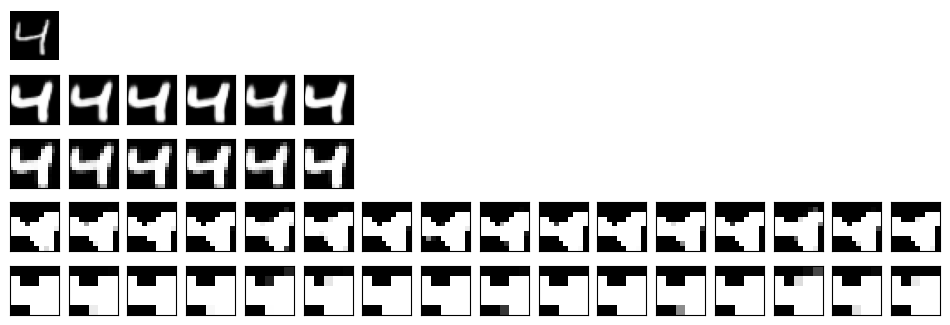

In [7]:
# hyperparameters
np.random.seed(30)
lr = 0.1
epochs = 1

lenet = LeNet5(trainset,testset)
lenet.train(lr, epochs)

img = trainset[2][0]
outputs = lenet.forwardpass(img)
print(outputs)
print(np.argmax(outputs))

fig, ax = plt.subplots(nrows=5, ncols=16, figsize=(12, 4))
for i in range(16):
  for j in range(5):
    ax[j][i].axis("off")
ax[0][0].imshow(img,cmap='gray')
for j in range(4):
  for i in range(len(lenet.conv_imgs[j])):
    ax[j+1][i].axis("on")
    ax[j+1][i].set_xticks([])
    ax[j+1][i].set_yticks([])
    ax[j+1][i].imshow(lenet.conv_imgs[j][i],cmap='gray')